In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.16.1


In [17]:
# Load and prepare the dataset
file_path = 'tsmc_prices_close_only_datetime_2010-2018.csv'  # Make sure to have your dataset ready
df = pd.read_csv(file_path)
data = df[['close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Parameters
time_step = 100
training_size = int(len(data_scaled) * 0.7)
test_size = len(data_scaled) - training_size
train_data, test_data = data_scaled[0:training_size,:], data_scaled[training_size:len(data_scaled),:]

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (1449, 100, 1)
y_train shape: (1449,)
X_test shape: (564, 100, 1)
y_test shape: (564,)


In [18]:
# Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

In [19]:
# Model Definition
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D(data_format='channels_first')(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error")

# Model Summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 1)    │          2 │ input_layer_2[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 1)    │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 100, 1)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 100, 1)    │          0 │ dropout_9[0][0],  │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 1)    │          2 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 100, 4)    │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 100, 4)    │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 100, 1)    │          5 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 100, 1)    │          0 │ dense_9[0][0],    │
│                     │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 100)       │          0 │ add_5[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 100)       │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 20)        │      2,020 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         21 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,227 (36.04 KB)

 Trainable params: 9,227 (36.04 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0879 - val_loss: 0.2837
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0217 - val_loss: 0.0395
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0096 - val_loss: 0.0057
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0093 - val_loss: 0.0073
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0075 - val_loss: 0.0111
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0064 - val_loss: 0.0053
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0056 - val_loss: 0.0068
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0

In [21]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse Transform
train_real = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1)).flatten()

test_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1)).flatten()

# Evaluate the model (Optional: Calculate RMSE or other metrics)
train_rmse = math.sqrt(mean_squared_error(train_real, train_predict))
test_rmse = math.sqrt(mean_squared_error(test_real, test_predict))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Train RMSE: 4.0786507659672315
Test RMSE: 13.30059916648324


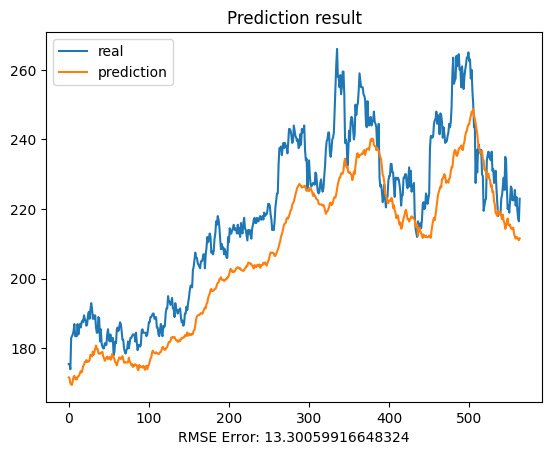

In [22]:
plt.figure(1)
plt.plot(test_real, label='real')
plt.plot(test_predict, label='prediction')
# plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
rmse = np.sqrt(mean_squared_error(test_real, test_predict))
plt.xlabel('RMSE Error: {}'.format(rmse))
plt.legend()
plt.title('Prediction result')
plt.show()